In [1]:
import cv2
import scipy 
import skimage
import numpy as np
import matplotlib.pyplot as plt

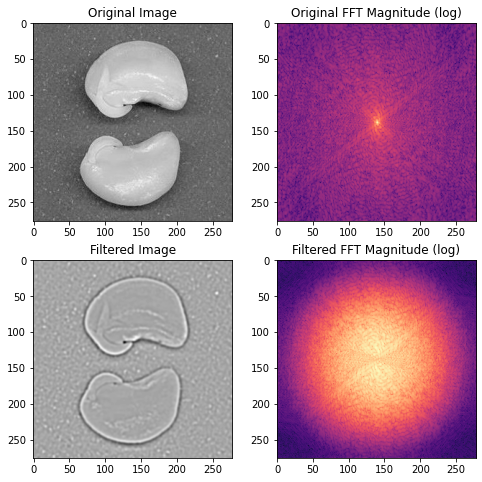

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift

imagem = cv2.imread('/content/R2_IN.jpg')
imager = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(imager, cv2.COLOR_BGR2GRAY)

wimage = image * window('hann', image.shape)
filtered_image = difference_of_gaussians(image, 1.5)
filtered_wimage = filtered_image * window('hann', image.shape)
im_f_mag = fftshift(np.abs(fftn(wimage)))
fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(np.log(im_f_mag), cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')
ax[1, 0].imshow(filtered_image, cmap='gray')
ax[1, 0].set_title('Filtered Image')
ax[1, 1].imshow(np.log(fim_f_mag), cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')
plt.show()

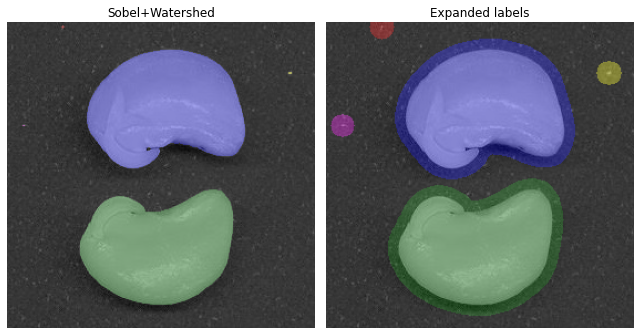

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import watershed, expand_labels
from skimage.color import label2rgb
from skimage import data

bean = cv2.imread('/content/R2_IN.jpg',0)

# Make segmentation using edge-detection and watershed.
edges = sobel(bean)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(bean)
foreground, background = 1, 2
markers[bean < 30.0] = background
markers[bean > 150.0] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

expanded = expand_labels(seg1, distance=10)

# Show the segmentations.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5),
                         sharex=True, sharey=True)

color1 = label2rgb(seg1, image=bean, bg_label=0)
axes[0].imshow(color1)
axes[0].set_title('Sobel+Watershed')

color2 = label2rgb(expanded, image=bean, bg_label=0)
axes[1].imshow(color2)
axes[1].set_title('Expanded labels')

for a in axes:
    a.axis('off')
fig.tight_layout()
plt.show()

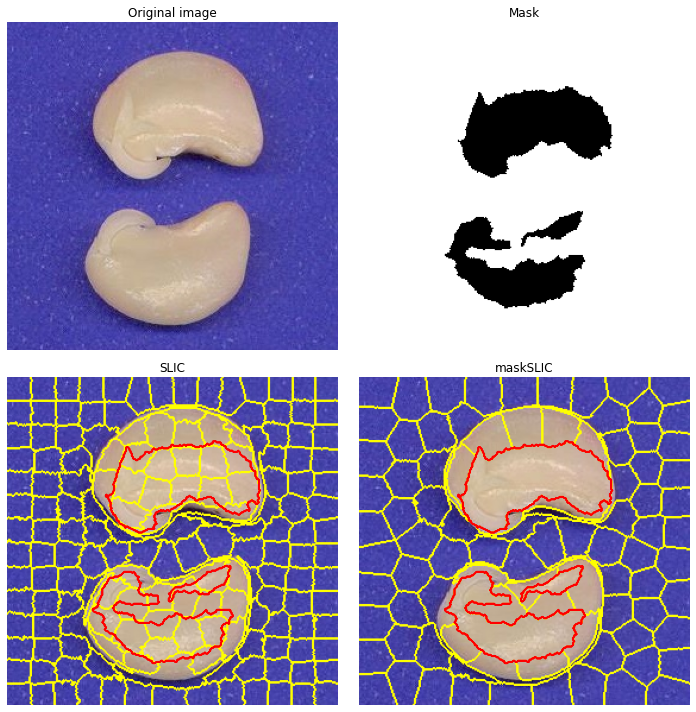

In [4]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation

# Input data

imagem = cv2.imread('/content/R2_IN.jpg')
img = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

# Compute a mask
lum = color.rgb2gray(img)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < 0.7, 500),
    500)

mask = morphology.opening(mask, morphology.disk(3))

# SLIC result
slic = segmentation.slic(img, n_segments=200, start_label=1)

# maskSLIC result
m_slic = segmentation.slic(img, n_segments=100, mask=mask, start_label=1)

# Display result
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(img)
ax1.set_title('Original image')

ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask')

ax3.imshow(segmentation.mark_boundaries(img, slic))
ax3.contour(mask, colors='red', linewidths=1)
ax3.set_title('SLIC')

ax4.imshow(segmentation.mark_boundaries(img, m_slic))
ax4.contour(mask, colors='red', linewidths=1)
ax4.set_title('maskSLIC')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

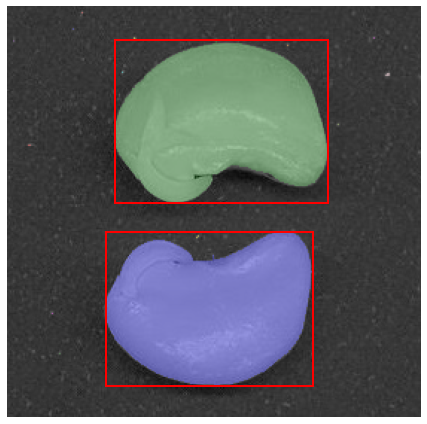

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


image = cv2.imread('/content/R2_IN.jpg',0)

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(4))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
      
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

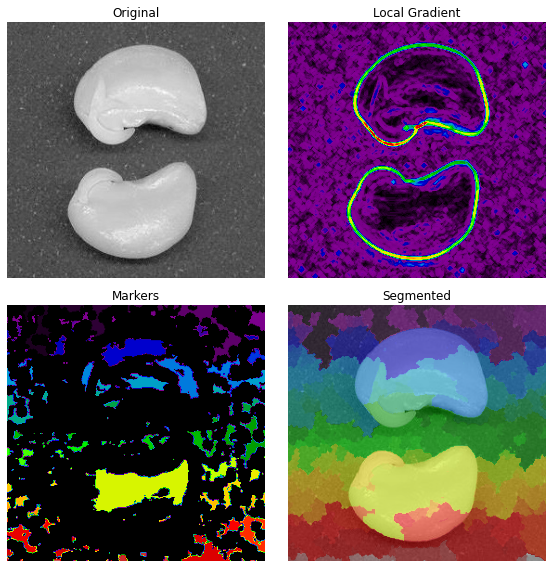

In [6]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

image = img_as_ubyte(cv2.imread('/content/R2_IN.jpg',0))


# denoise image
denoised = rank.median(image, disk(2))

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(5)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(2))

# process the watershed
labels = watershed(gradient, markers)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Markers")

ax[3].imshow(image, cmap=plt.cm.gray)
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Previously, sato implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  app.launch_new_instance()


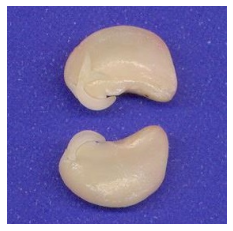

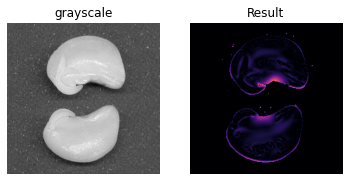

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import color, data, filters, graph, measure, morphology

imagem = cv2.imread('/content/R2_IN.jpg')
source = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

_, ax = plt.subplots()
ax.imshow(source)
ax.set_axis_off()

retina = color.rgb2gray(source)
t0, t1 = filters.threshold_multiotsu(retina, classes=3)
mask = (retina > t0)
vessels = filters.sato(retina, sigmas=range(1, 10)) * mask

_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(retina, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Result')